<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import plotting_tools as plts
import Residual_blocks as resblock
import Bottleneck_residual_blocks as bresblock
import history as hist

Cloning into 'AE-w.-Bottleneck-Residual-Blocks'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 122 (delta 58), reused 68 (delta 22), pack-reused 0
Receiving objects: 100% (122/122), 106.04 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL1VE3E/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL1VE3E/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

# x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [9]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(x)

# x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_54 (ReLU)             (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_55 (ReLU)             (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_56 (ReLU)             (None, 1024)              0   

In [10]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         17307139  
                                                                 
Total params: 31154243 (118.84 MB)
Trainable params: 31133251 (118.76 MB)
Non-trainable params: 20992 (82.00 KB)
_________________________________________________________________


In [11]:
K.clear_session()

In [12]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75)

Epoch 1/75
391/391 [==============================] - 76s 129ms/step - loss: 0.0201 - val_loss: 0.0289
Epoch 2/75
391/391 [==============================] - 49s 124ms/step - loss: 0.0129 - val_loss: 0.0141
Epoch 3/75
391/391 [==============================] - 49s 124ms/step - loss: 0.0121 - val_loss: 0.0186
Epoch 4/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0117 - val_loss: 0.0144
Epoch 5/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0114 - val_loss: 0.0138
Epoch 6/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0112 - val_loss: 0.0132
Epoch 7/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 8/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0108 - val_loss: 0.0130
Epoch 9/75
391/391 [==============================] - 49s 125ms/step - loss: 0.0107 - val_loss: 0.0142
Epoch 10/75
391/391 [==============================] - 49s 124ms/step - l

In [13]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8, verbose=1, start_from_epoch=5)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40)

Epoch 1/40
391/391 [==============================] - 76s 129ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 2/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 3/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 4/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 5/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 6/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 7/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 8/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 9/40
391/391 [==============================] - 49s 125ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 10/40
391/391 [==============================] - 49s 125ms/step - l

In [14]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.000001)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20)

Epoch 1/20
391/391 [==============================] - 76s 129ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 2/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 3/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 4/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 5/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 6/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 7/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 8/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 9/20
391/391 [==============================] - 49s 125ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 10/20
391/391 [==============================] - 49s 125ms/step - l

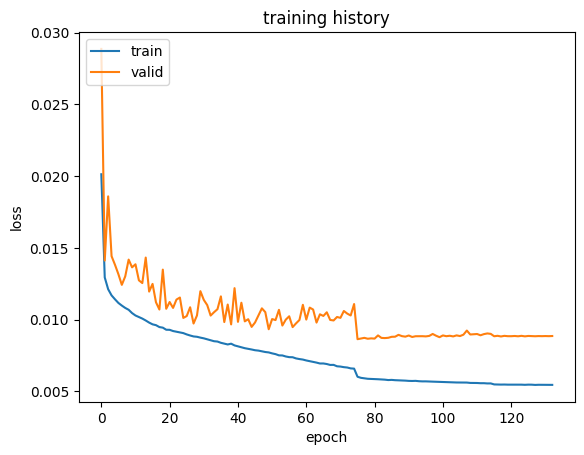

In [16]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

In [18]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

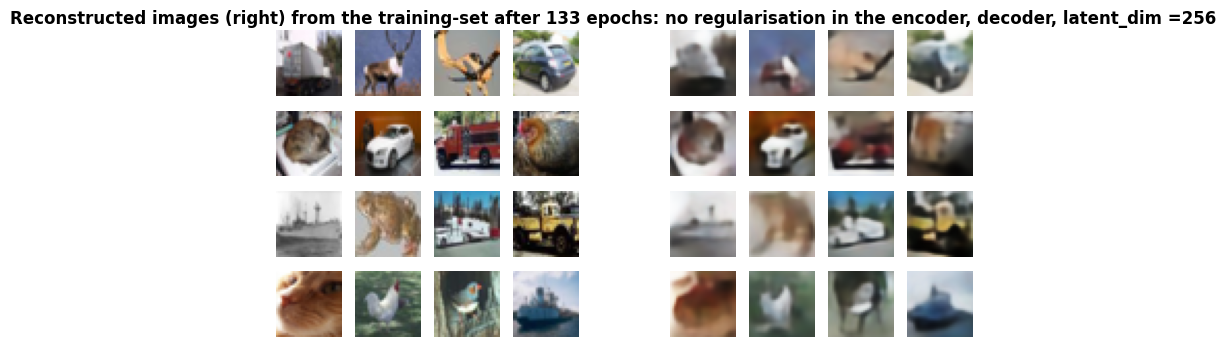

In [19]:
plot_reconstruction(img_train, 'training', 123, 133)

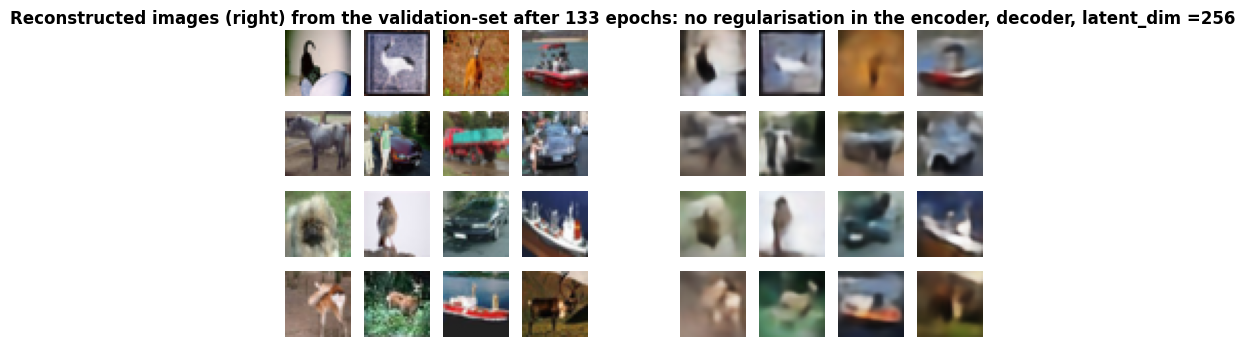

In [20]:
plot_reconstruction(img_valid, 'validation', 123, 133)

This is the best training set performance obtained, so the model has converged better, but it's not the best validation set performance, so it has done worse in terms of generalisation.